# Movie sentiment classification (LSTM)


## Load libraries


In [8]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
# tf and keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# natural language processing toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download once
nltk.download('punkt')
nltk.download('stopwords')

print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop/IT1244/Project


[nltk_data] Downloading package punkt to /Users/swislar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swislar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Main


### Importing and Data cleaning


Functions for importing and cleaning the data


In [12]:
# Function to load data into a pandas dataframe while cleaning (text) data
warnings.simplefilter("ignore", MarkupResemblesLocatorWarning)


def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: List containing words from the sentence after stemming and removing stop words and HTML tags
    '''
    # Remove HTML Tags
    clean = BeautifulSoup(TEXT, "html.parser")
    # Tokenize the sentence
    words = word_tokenize(clean.get_text())
    # Remove stop words and get word stem
    porter = PorterStemmer()
    filtered_words = [porter.stem(word) for word in words if word.lower()
                      not in stopwords.words('english') and
                      word not in string.punctuation and word.strip() not in ['', '``', '""', "''"]]
    return filtered_words


def loadAllData(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "rating", "sentiment", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID, posRating = int(posDetails[0]), int(posDetails[1])
        # Add data into the Dataframe
        row = {"id": posID, "rating": posRating,
               "sentiment": 1, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID, negRating = int(negDetails[0]) + 25000, int(negDetails[1])
        row = {"id": negID, "rating": negRating,
               "sentiment": 0, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

Code chunks for loading the data from a parquet (faster) and loading the data manually from individual files


In [14]:
# Load data using parquet instead of individual files and cleaning them
dataframe = pd.read_parquet(os.path.join(wd, "movieReviews.parquet"))
# Convert each of these into a list to be passed for tokenize if read_parquet is used
dataframe.text = dataframe.text.apply(lambda x: list(x))

In [13]:
# Load data (Takes approximately 12 mins)
dataframe = loadAllData()
dataframe.head(5)

Processing Negative Reviews: 100%|██████████| 25000/25000 [06:02<00:00, 69.01it/s]


,id,rating,sentiment,text
0,20935,9,1,"[watch, return, lonesom, dove, good, 've, seen..."
1,12390,8,1,"[movi, look, like, classic, cheesi, 80, slashe..."
2,9820,8,1,"[jay, chou, play, orphan, rais, kung, fu, scho..."
3,883,7,1,"[ooveral, movi, fairli, good, good, action, pl..."
4,9063,8,1,"[movi, fun, watch, like, dave, kevin, klein, g..."


In [15]:
# Check if data is properly classified
print(
    f"Correctly classified ratings: {sum(np.where(dataframe['rating'] < 5, 0, 1) == dataframe['sentiment'])}/{dataframe.shape[0]}")

Correctly classified ratings: 25000/50000


### Split training, validation and testing data sets


In [20]:
# Divide positive and negative reviews into test, train and validation sets
df_pos = dataframe[dataframe['rating'] >= 5]
df_neg = dataframe[dataframe['rating'] < 5]
print(f'Shape of df_pos is {df_pos.shape}')
print(f'Shape of df_neg is {df_neg.shape}\n')
# Shuffle the data into its group
df_pos = shuffle(df_pos, random_state=321)
df_neg = shuffle(df_neg, random_state=123)
# Training(0.7), test(0.15) and validation(0.15) data for the pos set
x_pos = df_pos['text']
# y_pos = df_pos['rating']
y_pos = df_pos['sentiment']
x_train_pos, x_test_temp, y_train_pos, y_test_temp = train_test_split(
    x_pos, y_pos, test_size=0.3, random_state=99)
x_test_pos, x_valid_pos, y_test_pos, y_valid_pos = train_test_split(
    x_test_temp, y_test_temp, test_size=0.5, random_state=99)
# Training(0.7), test(0.15) and validation(0.15) data for the neg set
x_neg = df_neg['text']
# y_neg = df_neg['rating']
y_neg = df_neg['sentiment']
x_train_neg, x_test_temp, y_train_neg, y_test_temp = train_test_split(
    x_neg, y_neg, test_size=0.3, random_state=99)
x_test_neg, x_valid_neg, y_test_neg, y_valid_neg = train_test_split(
    x_test_temp, y_test_temp, test_size=0.5, random_state=99)
# Join the pos and neg sets together and shuffle them
x_train = pd.concat([x_train_pos, x_train_neg], axis=0)
x_test = pd.concat([x_test_pos, x_test_neg], axis=0)
x_valid = pd.concat([x_valid_pos, x_valid_neg], axis=0)
y_train = pd.concat([y_train_pos, y_train_neg], axis=0)
y_test = pd.concat([y_test_pos, y_test_neg], axis=0)
y_valid = pd.concat([y_valid_pos, y_valid_neg], axis=0)
# Check if data is correctly split
print(f'Shape of x_train is {x_train.shape}')
print(f'Shape of x_test is {x_test.shape}')
print(f'Shape of x_valid is {x_valid.shape}\n')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')
print(f'Shape of y_valid is {y_valid.shape}')

Shape of df_pos is (25000, 4)
Shape of df_neg is (25000, 4)

Shape of x_train is (35000,)
Shape of x_test is (7500,)
Shape of x_valid is (7500,)

Shape of y_train is (35000,)
Shape of y_test is (7500,)
Shape of y_valid is (7500,)


### Conversion of words into sequences


In [24]:
# Obtain the list of vocabulary size from the training dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.tolist())
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
index_word = {i: word for word, i in word_index.items()}
index_word[0] = ""
print(f'Vocab size: {vocab_size}')

# convert words into sequences to input into the model
x_train_seq = tokenizer.texts_to_sequences(x_train.tolist())
x_test_seq = tokenizer.texts_to_sequences(x_test.tolist())
x_valid_seq = tokenizer.texts_to_sequences(x_valid.tolist())

# convert results y into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

# Pad sequences to make them uniform in length
max_seq_len = max(len(x) for x in x_train.tolist())
print(f'Max sequence length: {max_seq_len}')
x_train_padded = pad_sequences(x_train_seq, maxlen=max_seq_len, padding='post')
x_test_padded = pad_sequences(
    x_test_seq, maxlen=max_seq_len, padding='post')
x_valid_padded = pad_sequences(
    x_valid_seq, maxlen=max_seq_len, padding='post')

Vocab size: 133428
Max sequence length: 1451


In [1]:
# print(f'Sample padded sequence: {x_train_padded[999].tolist()}')
# print(f'Sequence uncoded: {[index_word.get(i) for i in x_train_padded[999]]}')

### Initialising the model, train and test (1)


Using the first set of parameters </br>

<ul>
    <li>embedding_dim = 32</li>
    <li>hidden_units = 64</li>
    <li>2 bidirectional LSTM layers</li>
</ul>
</br>
to determine the best parameter which will result in the highest accuracy


In [44]:
# Initialize the model
model = Sequential()
embedding_dim = 32
hidden_units = 64

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer with dropout and batch normalization
model.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=hidden_units)))
model.add(Dropout(0.5))  # Another Dropout layer
model.add(BatchNormalization())  # Another Batch Normalization layer

# Add a Dense output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Implement early stopping with ModelCheckpoint
checkpoint = ModelCheckpoint(
    os.path.join(wd, "best_model.h5"),
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    # Save based on maximizing the monitored quantity (val_accuracy)
    mode='max',
    verbose=1
)

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)

# Combine callbacks into a list
callbacks = [checkpoint, early_stopping]

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1451, 32)          5177152   
                                                                 
 bidirectional_7 (Bidirecti  (None, 1451, 128)         49664     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 1451, 128)         0         
                                                                 
 batch_normalization_7 (Bat  (None, 1451, 128)         512       
 chNormalization)                                                
                                                                 
 bidirectional_8 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                      

In [45]:
# Train the model
history = model.fit(x_train_padded, y_train, epochs=5,
                    batch_size=128, validation_data=(x_valid_padded, y_valid))

Epoch 1/5
274/274 [==============================] - 976s 4s/step - loss: 0.4799 - accuracy: 0.7744 - val_loss: 0.3447 - val_accuracy: 0.8555
Epoch 2/5
274/274 [==============================] - 969s 4s/step - loss: 0.2063 - accuracy: 0.9232 - val_loss: 0.5598 - val_accuracy: 0.7973
Epoch 3/5
274/274 [==============================] - 976s 4s/step - loss: 0.1274 - accuracy: 0.9558 - val_loss: 0.4047 - val_accuracy: 0.8493
Epoch 4/5
274/274 [==============================] - 986s 4s/step - loss: 0.0776 - accuracy: 0.9738 - val_loss: 0.4552 - val_accuracy: 0.8599
Epoch 5/5
274/274 [==============================] - 950s 3s/step - loss: 0.0451 - accuracy: 0.9856 - val_loss: 0.9087 - val_accuracy: 0.7840


In [47]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = model.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = model.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 57s 243ms/step - loss: 0.9087 - accuracy: 0.7840
Validation Accuracy: 78.39999794960022%
235/235 [==============================] - 55s 234ms/step - loss: 0.9261 - accuracy: 0.7792
Test Accuracy: 77.920001745224%


Using these set of parameters, the model was able to achieve an accuracy of approximately 85% before it starts to overfit.


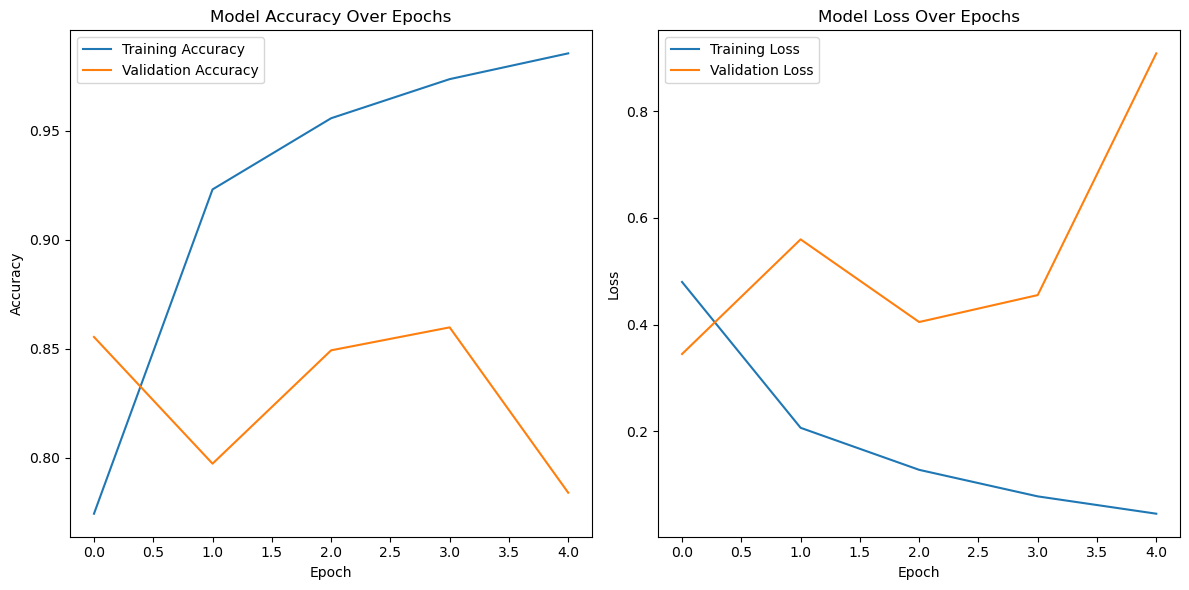

In [58]:
# Plot the accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

After the 3rd epoch, we can see that the model begins to overfit.


### Initialising the model, train and test (2)


Using the second set of parameters </br>

<ul>
    <li>embedding_dim = 32</li>
    <li>hidden_units = 64</li>
    <li>1 bidirectional LSTM layer</li>
</ul>


In [87]:
# Initialize the model
model2 = Sequential()
embedding_dim = 32
hidden_units = 64

# Add an Embedding layer
model2.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer with dropout and batch normalization
model2.add(Bidirectional(LSTM(units=hidden_units)))
model2.add(Dropout(0.5))  # Another Dropout layer
model2.add(BatchNormalization())  # Another Batch Normalization layer

# Add a Dense output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy',
               optimizer='adam', metrics=['accuracy'])

# Implement early stopping with ModelCheckpoint
checkpoint = ModelCheckpoint(
    os.path.join(wd, "best_model2.h5"),
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    # Save based on maximizing the monitored quantity (val_accuracy)
    mode='max',
    verbose=1
)

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)

# Combine callbacks into a list
callbacks = [checkpoint, early_stopping]

model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 1451, 32)          5177152   
                                                                 
 bidirectional_33 (Bidirect  (None, 128)               49664     
 ional)                                                          
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_28 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5227457 (19.94 MB)
Trainable params: 52

In [88]:
# Train the model
history2 = model2.fit(x_train_padded, y_train, epochs=5,
                      batch_size=128, validation_data=(x_valid_padded, y_valid))

Epoch 1/5
274/274 [==============================] - 345s 1s/step - loss: 0.4212 - accuracy: 0.7921 - val_loss: 0.4933 - val_accuracy: 0.7295
Epoch 2/5
274/274 [==============================] - 348s 1s/step - loss: 0.1780 - accuracy: 0.9335 - val_loss: 0.3212 - val_accuracy: 0.8849
Epoch 3/5
274/274 [==============================] - 350s 1s/step - loss: 0.0946 - accuracy: 0.9674 - val_loss: 0.3587 - val_accuracy: 0.8784
Epoch 4/5
274/274 [==============================] - 353s 1s/step - loss: 0.0519 - accuracy: 0.9821 - val_loss: 0.4723 - val_accuracy: 0.8732
Epoch 5/5
274/274 [==============================] - 352s 1s/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.5366 - val_accuracy: 0.8689


In [89]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = model2.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = model2.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 17s 71ms/step - loss: 0.5366 - accuracy: 0.8689
Validation Accuracy: 86.89333200454712%
235/235 [==============================] - 17s 71ms/step - loss: 0.5317 - accuracy: 0.8640
Test Accuracy: 86.40000224113464%


Using a simpler model with 1 less bidirectional LSTM layer, we were able to obtain a higher accuracy of approximately 87%


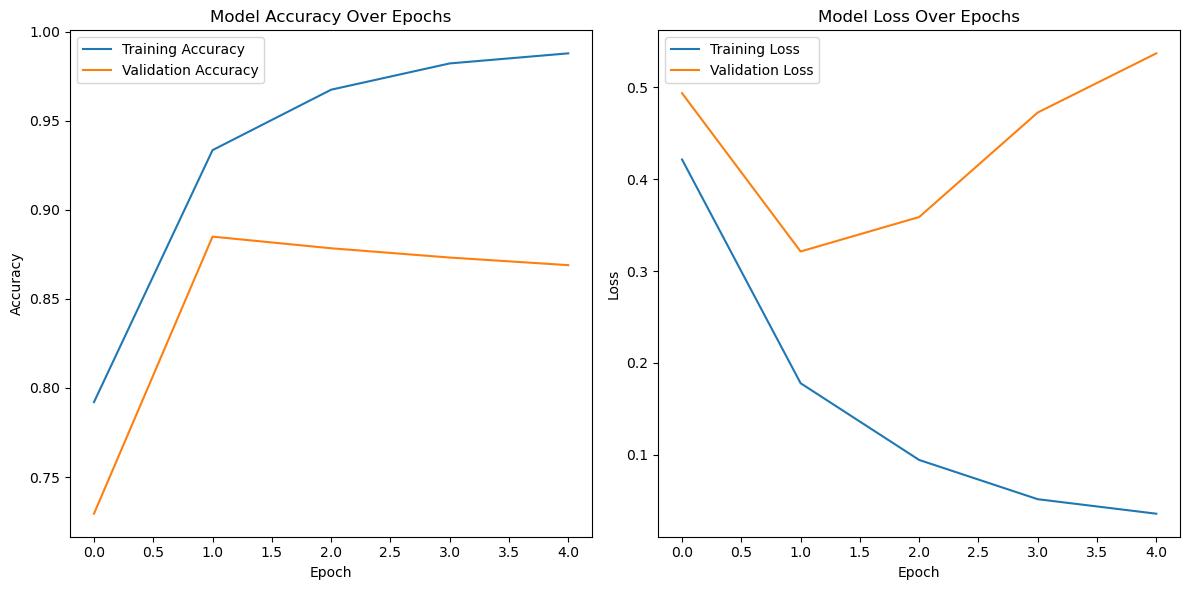

In [92]:
# Plot the accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Using these set of parameters, the model begins to overfit after the first epoch


### Initialising the model, train and test (3)


Using the third set of parameters </br>

<ul>
    <li>embedding_dim = 32</li>
    <li>hidden_units = 24</li>
    <li>2 bidirectional LSTM layers</li>
</ul>


In [11]:
# Initialize the model
model3 = Sequential()
embedding_dim = 32
hidden_units = 24

# Add an Embedding layer
model3.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer with dropout and batch normalization
model3.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())

model3.add(Bidirectional(LSTM(units=hidden_units)))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())

# Add a Dense output layer
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy',
               optimizer='adam', metrics=['accuracy'])

# Implement early stopping with ModelCheckpoint
checkpoint = ModelCheckpoint(
    os.path.join(wd, "best_model3.h5"),
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    # Save based on maximizing the monitored quantity (val_accuracy)
    mode='max',
    verbose=1
)

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)

# Combine callbacks into a list
callbacks = [checkpoint, early_stopping]

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1451, 32)          4269696   
                                                                 
 bidirectional (Bidirection  (None, 1451, 48)          10944     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1451, 48)          0         
                                                                 
 batch_normalization (Batch  (None, 1451, 48)          192       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 48)                14016     
 onal)                                                           
                                                        

In [12]:
# Train the model
history3 = model3.fit(x_train_padded, y_train, epochs=10,
                      batch_size=128, validation_data=(x_valid_padded, y_valid))

Epoch 1/10
274/274 [==============================] - 238s 860ms/step - loss: 0.5139 - accuracy: 0.7486 - val_loss: 0.4379 - val_accuracy: 0.8227
Epoch 2/10
274/274 [==============================] - 242s 884ms/step - loss: 0.2304 - accuracy: 0.9174 - val_loss: 0.3639 - val_accuracy: 0.8355
Epoch 3/10
274/274 [==============================] - 235s 858ms/step - loss: 0.1222 - accuracy: 0.9625 - val_loss: 0.3841 - val_accuracy: 0.8843
Epoch 4/10
274/274 [==============================] - 238s 869ms/step - loss: 0.0749 - accuracy: 0.9781 - val_loss: 0.3994 - val_accuracy: 0.8651
Epoch 5/10
274/274 [==============================] - 236s 861ms/step - loss: 0.0508 - accuracy: 0.9856 - val_loss: 0.5865 - val_accuracy: 0.8559
Epoch 6/10
274/274 [==============================] - 242s 882ms/step - loss: 0.0402 - accuracy: 0.9879 - val_loss: 0.5660 - val_accuracy: 0.8639
Epoch 7/10
274/274 [==============================] - 239s 874ms/step - loss: 0.0276 - accuracy: 0.9919 - val_loss: 0.6532 -

In [13]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = model3.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = model3.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 18s 76ms/step - loss: 0.7714 - accuracy: 0.8693
Validation Accuracy: 86.93333268165588%
235/235 [==============================] - 18s 76ms/step - loss: 0.7440 - accuracy: 0.8664
Test Accuracy: 86.64000034332275%


With these set of parameters, the model performs similarly to the 2nd set of parameters, with an accuracy of approximately 87%


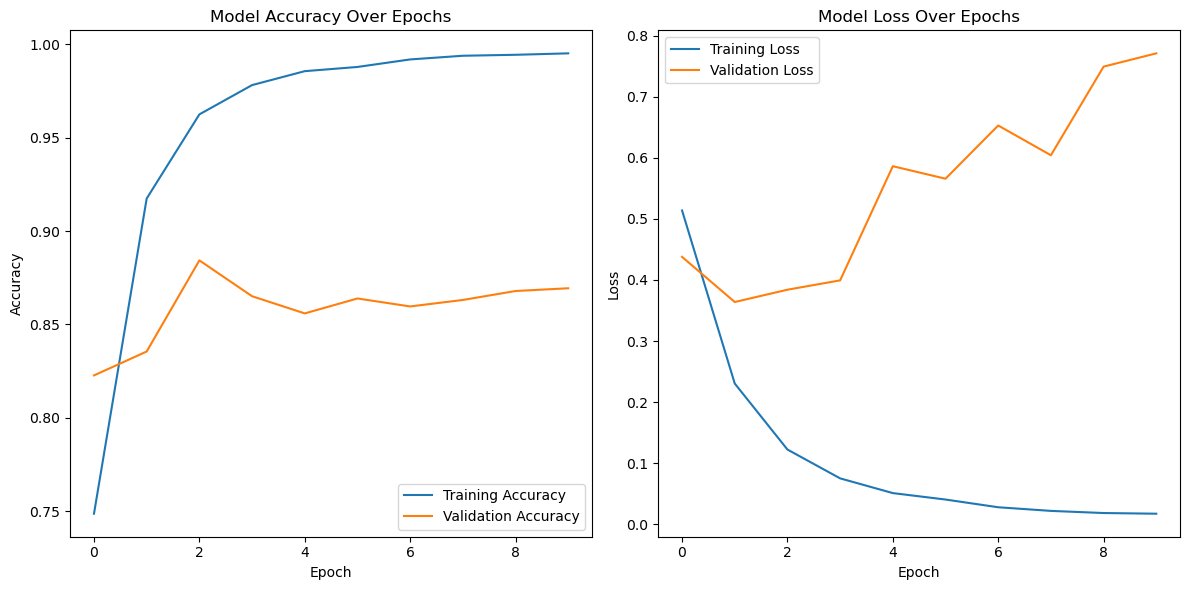

In [14]:
# Plot the accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

This model also starts of overfit after the 3rd epoch as the validation loss begins to increase drastically after each epoch


In [ ]:
# Load data using csv instead of individual files and cleaning them
dataframe = pd.read_parquet(os.path.join(wd, "movieReviews.parquet"))
# Convert each of these into a list to be passed for tokenize if read_parquet is used
dataframe.text = dataframe.text.apply(lambda x: list(x))

### Initialising the model, train and test (4)


Using the fourth set of parameters </br>

<ul>
    <li>embedding_dim = 32</li>
    <li>hidden_units = 16</li>
    <li>1 bidirectional LSTM layers</li>
</ul>


In [15]:
# Initialize the model
model4 = Sequential()
embedding_dim = 32
hidden_units = 16

# Add an Embedding layer
model4.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer with dropout and batch normalization
model4.add(Bidirectional(LSTM(units=hidden_units)))
model4.add(Dropout(0.5))
model4.add(BatchNormalization())

# Add a Dense output layer
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(loss='binary_crossentropy',
               optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1451, 32)          4269696   
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4276129 (16.31 MB)
Trainable params: 427

In [16]:
# Train the model
history4 = model4.fit(x_train_padded, y_train, epochs=10,
                      batch_size=128, validation_data=(x_valid_padded, y_valid), callbacks=[early_stopping])

Epoch 1/10
274/274 [==============================] - 83s 298ms/step - loss: 0.4191 - accuracy: 0.7987 - val_loss: 0.3301 - val_accuracy: 0.8816
Epoch 2/10
274/274 [==============================] - 80s 292ms/step - loss: 0.1803 - accuracy: 0.9399 - val_loss: 0.2988 - val_accuracy: 0.8875
Epoch 3/10
274/274 [==============================] - 80s 292ms/step - loss: 0.0977 - accuracy: 0.9689 - val_loss: 0.3746 - val_accuracy: 0.8759
Epoch 4/10
274/274 [==============================] - 81s 294ms/step - loss: 0.0598 - accuracy: 0.9818 - val_loss: 0.5442 - val_accuracy: 0.8667
Epoch 5/10
274/274 [==============================] - 81s 297ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.5389 - val_accuracy: 0.8597
Epoch 6/10
274/274 [==============================] - 83s 302ms/step - loss: 0.0319 - accuracy: 0.9906 - val_loss: 0.6530 - val_accuracy: 0.8685
Epoch 7/10
274/274 [==============================] - 83s 303ms/step - loss: 0.0359 - accuracy: 0.9886 - val_loss: 0.9113 - val_ac

In [17]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = model4.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = model4.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 7s 31ms/step - loss: 0.7744 - accuracy: 0.8628
Validation Accuracy: 86.28000020980835%
235/235 [==============================] - 7s 31ms/step - loss: 0.7527 - accuracy: 0.8655
Test Accuracy: 86.54666543006897%


With a less complex model, the model was able to achieve greatest validation accuracy of 88.75% with a low validation loss of 0.2988


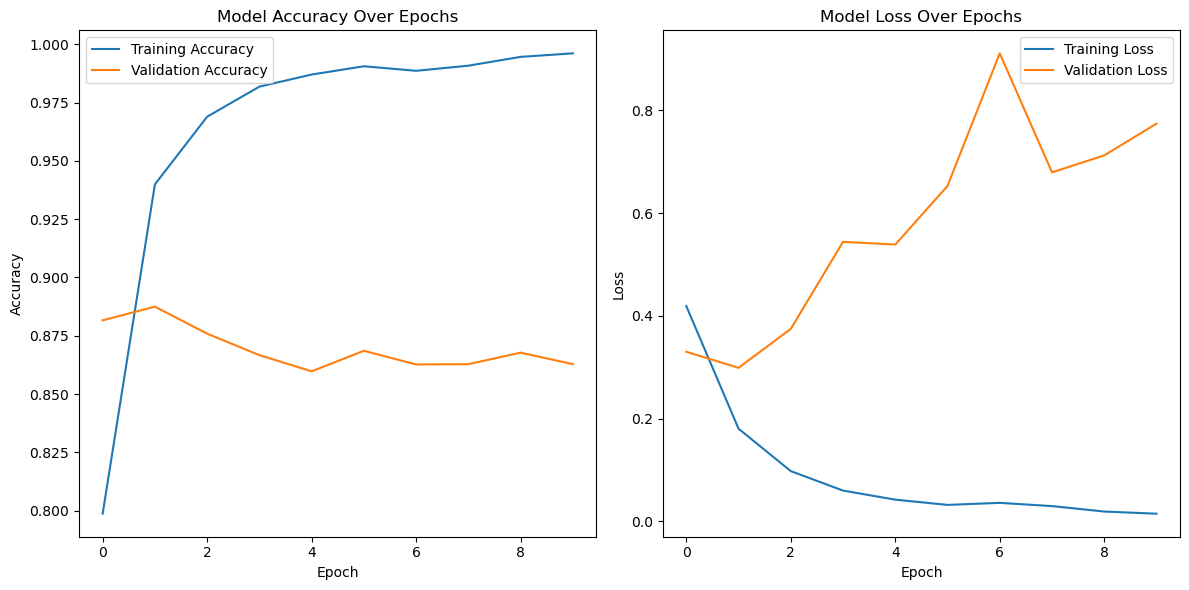

In [18]:
# Plot the accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

However, this model also begins to overfit after the first epoch


## Final model


The set of parameters used for the final LSTM model </br>

<ul>
    <li>embedding_dim = 50</li>
    <li>hidden_units = 32</li>
    <li>1 bidirectional LSTM layers</li>
</ul>


In [31]:
# Initialize the model
modelFinal = Sequential()
embedding_dim = 50
hidden_units = 32

# Add an Embedding layer
modelFinal.add(Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim, input_length=max_seq_len))

# Add a Bidirectional LSTM layer with dropout and batch normalization
modelFinal.add(Bidirectional(LSTM(units=hidden_units)))
modelFinal.add(Dropout(0.5))
modelFinal.add(BatchNormalization())

# Add a Dense output layer
modelFinal.add(Dense(1, activation='sigmoid'))

# Compile the model
modelFinal.compile(loss='binary_crossentropy',
                   optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

modelFinal.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1451, 50)          6671400   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                21248     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6692969 (25.53 MB)
Trainable params: 669

In [32]:
# Train the model
historyFinal = modelFinal.fit(x_train_padded, y_train, epochs=10,
                              batch_size=128, validation_data=(x_valid_padded, y_valid), callbacks=[early_stopping])

Epoch 1/10
274/274 [==============================] - 196s 709ms/step - loss: 0.3915 - accuracy: 0.8135 - val_loss: 0.3393 - val_accuracy: 0.8895
Epoch 2/10
274/274 [==============================] - 192s 699ms/step - loss: 0.1676 - accuracy: 0.9411 - val_loss: 0.2908 - val_accuracy: 0.8856
Epoch 3/10
274/274 [==============================] - 190s 693ms/step - loss: 0.0854 - accuracy: 0.9714 - val_loss: 0.4426 - val_accuracy: 0.8624
Epoch 4/10
274/274 [==============================] - 190s 692ms/step - loss: 0.0514 - accuracy: 0.9839 - val_loss: 0.5592 - val_accuracy: 0.8652
Epoch 5/10
274/274 [==============================] - 191s 695ms/step - loss: 0.0329 - accuracy: 0.9896 - val_loss: 0.5455 - val_accuracy: 0.8701
Epoch 5: early stopping


In [33]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = modelFinal.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = modelFinal.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 11s 46ms/step - loss: 0.2908 - accuracy: 0.8856
Validation Accuracy: 88.55999708175659%
235/235 [==============================] - 11s 46ms/step - loss: 0.2948 - accuracy: 0.8812
Test Accuracy: 88.12000155448914%


With this model, we were able to obtain the lowest validation loss and the highest accuracy for review sentiment analysis


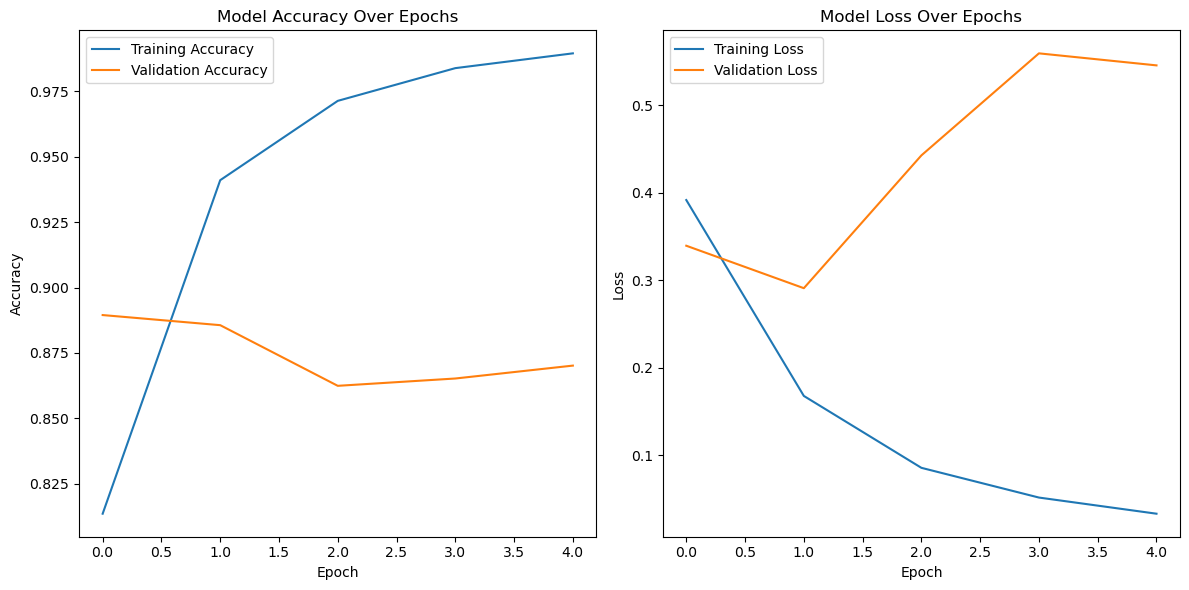

In [34]:
# Plot the accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(historyFinal.history['accuracy'], label='Training Accuracy')
plt.plot(historyFinal.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(historyFinal.history['loss'], label='Training Loss')
plt.plot(historyFinal.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

As the model begins to overfit after the first epoch, we took the weights from the first epoch to use it in our model which prevents overfitting


## References


1. Comparison of different models on sentiment analysis </br>
   https://towardsdatascience.com/sentiment-analysis-comparing-3-common-approaches-naive-bayes-lstm-and-vader-ab561f834f89

2. Deep Learning vs Machine Learning with Text classification </br>
   https://vasista.medium.com/deep-learning-vs-machine-learning-with-text-classification-162ea20a7924

3. Text classification with machine learning </br>
   https://monkeylearn.com/blog/text-classification-machine-learning/
4. Sentiment Analysis with RNN 1 </br>
   https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
5. Sentiment Analysis with RNN 2</br>
   https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/
6. Text classification with RNN </br>
   https://www.tensorflow.org/text/tutorials/text_classification_rnn


# Movies Sentiment (Naive Bayes)


## Load libraries


In [45]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
# keras and sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# natural language processing toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Download once
nltk.download('punkt')
nltk.download('stopwords')

print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop/IT1244/Project


[nltk_data] Downloading package punkt to /Users/swislar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swislar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Main


### Importing data and data cleaning


Functions for loading and cleaning data


In [29]:
def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: Text clean of HTML tags
    '''
    # Remove HTML Tags
    clean = BeautifulSoup(TEXT, "html.parser")
    return str(clean)


def loadAllData_nb(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "rating", "sentiment", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID, posRating = int(posDetails[0]), int(posDetails[1])
        # Add data into the Dataframe
        row = {"id": posID, "rating": posRating,
               "sentiment": 1, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID, negRating = int(negDetails[0]) + 25000, int(negDetails[1])
        row = {"id": negID, "rating": negRating,
               "sentiment": 0, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

In [30]:
dataframe_nb = loadAllData_nb()
dataframe_nb.head(5)

Processing Negative Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4310.04it/s]


,id,rating,sentiment,text
0,20935,9,1,"I just watched ""return from lonesome dove"" and..."
1,12390,8,1,This movie looked like a classic in the cheesy...
2,9820,8,1,Jay Chou plays an orphan raised in a kung fu s...
3,883,7,1,"Ooverall, the movie was fairly good, a good ac..."
4,9063,8,1,"This movie is fun to watch. If you liked ""Dave..."


Splitting the data equally into the training set (80%) and the testing set (20%)


In [41]:
# Divide positive and negative reviews into test, train and validation sets
df_pos = dataframe_nb[dataframe['rating'] >= 5]
df_neg = dataframe_nb[dataframe['rating'] < 5]
print(f'Shape of df_pos is {df_pos.shape}')
print(f'Shape of df_neg is {df_neg.shape}\n')
# Shuffle the data into its group
df_pos = shuffle(df_pos, random_state=321)
df_neg = shuffle(df_neg, random_state=123)
# Training(0.7) and test(0.2) for the pos set
x_pos = df_pos['text']
y_pos = df_pos['sentiment']
x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(
    x_pos, y_pos, test_size=0.2, random_state=99)
# Training(0.8) and test(0.2) for the neg set
x_neg = df_neg['text']
y_neg = df_neg['sentiment']
x_train_neg, x_test_neg, y_train_neg, y_test_neg = train_test_split(
    x_neg, y_neg, test_size=0.2, random_state=99)
# Join the pos and neg sets together and shuffle them
x_train = pd.concat([x_train_pos, x_train_neg], axis=0)
x_test = pd.concat([x_test_pos, x_test_neg], axis=0)
y_train = pd.concat([y_train_pos, y_train_neg], axis=0)
y_test = pd.concat([y_test_pos, y_test_neg], axis=0)
# Check if data is correctly split
print(f'Shape of x_train is {x_train.shape}')
print(f'Shape of x_test is {x_test.shape}\n')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of df_pos is (25000, 4)
Shape of df_neg is (25000, 4)

Shape of x_train is (40000,)
Shape of x_test is (10000,)

Shape of y_train is (40000,)
Shape of y_test is (10000,)


### Model


We vectorize the text and fit into the naive bayes model


In [43]:

vectorizer = TfidfVectorizer()
# Fit and transform the training data
x_train_vect = vectorizer.fit_transform(x_train)
# Transform the testing data
x_test_vect = vectorizer.transform(x_test)

# Initialize and train a Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train_vect, y_train)

# Predict on the testing data
y_pred = nb_classifier.predict(x_test_vect)

# Accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8588


After fitting the naive bayes model, we are able to obtain an accuracy of 85.88%


### Analysis of model


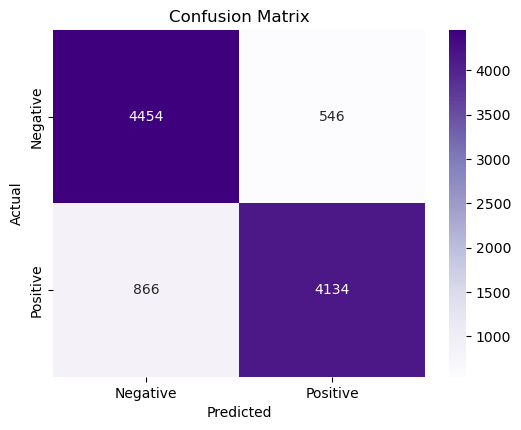

In [53]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, we can visualise the number true positives and negatives (top left and bottom right) to the number of false positives and negatives (bottom left and top right)


## References


1. Building Naive Bayes Classifier from Scratch to Perform Sentiment Analysis </br>
   https://www.analyticsvidhya.com/blog/2022/03/building-naive-bayes-classifier-from-scratch-to-perform-sentiment-analysis/
